In [521]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose,STL
import prophet


In [522]:
df = pd.read_csv('Base_EMBRAESP_trabalhada.csv')

In [523]:
df.columns

Index(['Unnamed: 0.1', 'ID', 'TIPO_EMP', 'MES_LAN', 'ANO_LAN', 'DATA_ENT',
       'DIST', 'SUBPREF', 'MUNICIPIO', 'TIPO_VIA', 'ZONA', 'DORM_UNID',
       'BANH_UNID', 'GAR_UNID', 'ELEV', 'COB', 'BLOCOS', 'UNIDAND', 'ANDARES',
       'AR_UT_UNID', 'AR_TT_UNID', 'AR_TT_TERR', 'TT_UNID', 'DORM_EMP',
       'BANH_EMP', 'GAR_EMP', 'AU_EMP', 'AT_EMP', 'PC_TT_UN', 'PC_M2_AU',
       'PC_M2_AT', 'PC_TT_ATU', 'PC_AU_ATU', 'PC_AT_ATU', 'PC_EMP_ATU',
       'VLR_US__CO', 'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'SIST_FINAN',
       'AGENTE', 'INCORPORAD', 'CONSTRUTOR', 'INCORPOR_A', 'CONSTRUT_A',
       'COOPERATIV', 'HOTEL', 'FLAT', 'EXFLAT', 'AP2010', 'SC_2010',
       'RENRESP91', 'RENRESP00', 'RENRESP10', 'PCMEDAU91', 'PCMEDAU00',
       'PCMEDAU10', 'BANH_DORM', 'Unnamed: 0', 'Domicílios_Setor',
       'Média_Moradores_por_domicilio_setor', 'Média_Renda_Responsaveis_Setor',
       'Domicilios no setor censitário', 'Domicilios alugados',
       'Domicilios unipessoais', 'Domicilios 2 ou 3 mo

In [524]:
df['DATA_ENT'].nunique()

403

In [525]:
df['DATA_ENT'].head(100)

0     15-JUL-2004
1     15-APR-2016
2     15-AUG-2015
3     15-MAR-2015
4     15-MAR-2015
         ...     
95    15-AUG-2008
96    15-AUG-2008
97    15-SEP-2001
98    15-JUL-2004
99    15-JUL-2004
Name: DATA_ENT, Length: 100, dtype: object

In [526]:
df['DATA_LANC'] = pd.to_datetime(df['MES_LAN'])

In [527]:
df_mes = df.resample('M', on='DATA_LANC').mean()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_11276\1048010194.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mes = df.resample('M', on='DATA_LANC').mean()


<AxesSubplot: xlabel='DATA_LANC', ylabel='PC_TT_ATU'>

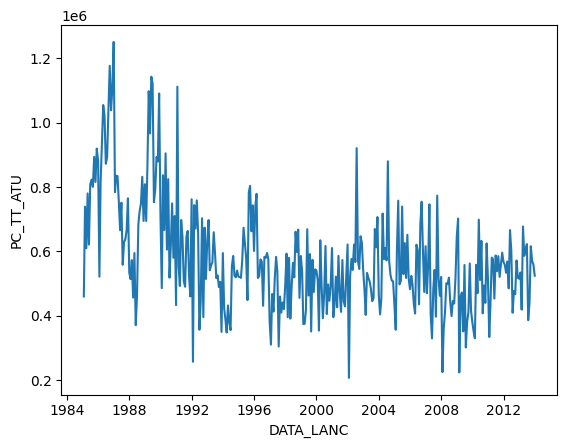

In [528]:
sns.lineplot(data=df_mes, x='DATA_LANC', y='PC_TT_ATU')

In [529]:
significancia = 0.05

teste_fuller_estac = adfuller(df_mes.index) #SEGUNDO NÚMERO DA TUPLA É O P-VALOR DA SIGNIFICÂNCIA

print ("O P-valor do teste é {}".format(teste_fuller_estac[1]))

O P-valor do teste é 0.9443960224340641


In [530]:
df_mes['media_movel'] = df_mes['PC_TT_ATU'].transform(func = lambda x : x.rolling(window=12).agg('mean')) #Realiza a média móvel a partir do número de períodos definidos na window
df_mes['desvio_movel'] = df_mes['PC_TT_ATU'].transform(func = lambda x : x.rolling(window=12).agg('std')) #Realiza o desvio móvel a partir do número de períodos definidos na window

lista = []

for x,mu,sigma in list(zip(df_mes['PC_TT_ATU'],df_mes['media_movel'],df_mes['desvio_movel'])):
    if (x > mu + 2 * sigma) | (x < mu - 2 * sigma):
        lista.append('outliers')
    else:
        lista.append('inliers')
        
df_mes['outliers'] = lista

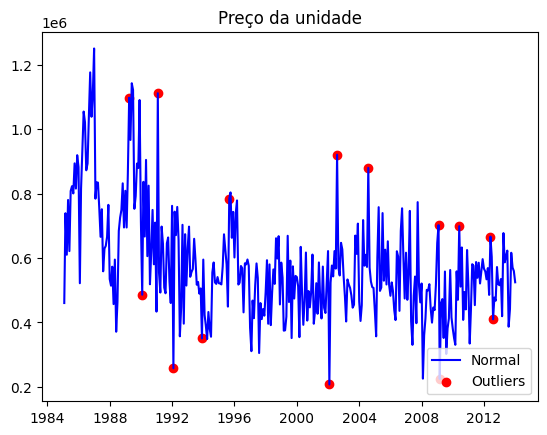

In [531]:
fig, ax = plt.subplots()
ax.plot(df_mes.index,df_mes['PC_TT_ATU'],color='blue', label='Normal')

z = df_mes[df_mes['outliers']=='outliers']
ax.scatter(z.index, z['PC_TT_ATU'],  color='red', label='Outliers')

ax.set_title("Preço da unidade")
ax.legend(loc='lower right')

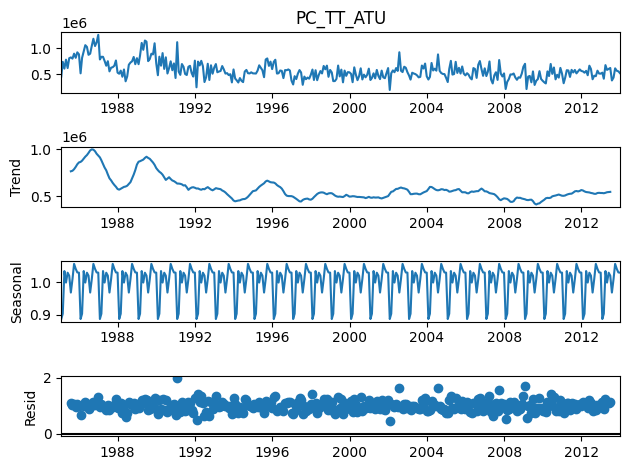

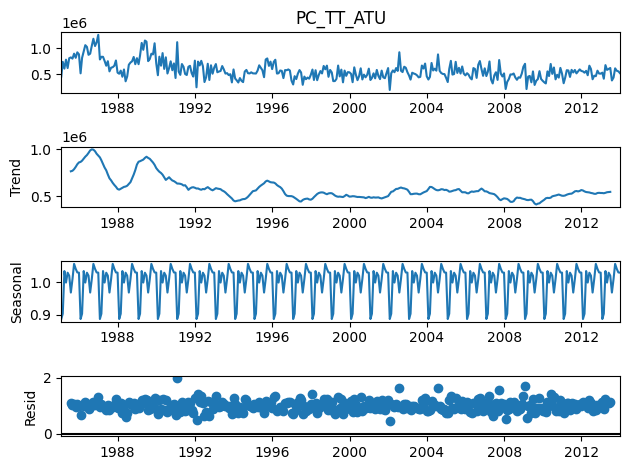

In [532]:
result = seasonal_decompose(df_mes['PC_TT_ATU'], model='multiplicative', period=12)
result.plot()

In [533]:
#df_mes['MES_LAN'] = pd.to_datetime(df_mes.index)
df_mes['MES_ANO_LAN'] = df_mes.index


In [534]:
train, test = [df_mes.iloc[0: 290], df.iloc[290:]]

#train = df.loc[df.index < split_date]
#test = df.loc[df.index >= split_date]

In [535]:
m = prophet.Prophet()

In [536]:
#test['MES_LAN'] = pd.to_datetime(test['MES_LAN'])

In [537]:
#train['MES_LANC'] = train.index

In [538]:
train.rename({'MES_ANO_LAN':'ds', 'PC_AU_ATU':'y'}, inplace=True, axis='columns')
#m.fit(train)

C:\Users\Pichau\AppData\Local\Temp\ipykernel_11276\2406890314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename({'MES_ANO_LAN':'ds', 'PC_AU_ATU':'y'}, inplace=True, axis='columns')


In [539]:
train['ds'].tail(100)

DATA_LANC
2000-11-30   2000-11-30
2000-12-31   2000-12-31
2001-01-31   2001-01-31
2001-02-28   2001-02-28
2001-03-31   2001-03-31
                ...    
2008-10-31   2008-10-31
2008-11-30   2008-11-30
2008-12-31   2008-12-31
2009-01-31   2009-01-31
2009-02-28   2009-02-28
Freq: M, Name: ds, Length: 100, dtype: datetime64[ns]

In [540]:
m.fit(train)

21:30:35 - cmdstanpy - INFO - Chain [1] start processing
21:30:35 - cmdstanpy - INFO - Chain [1] done processing


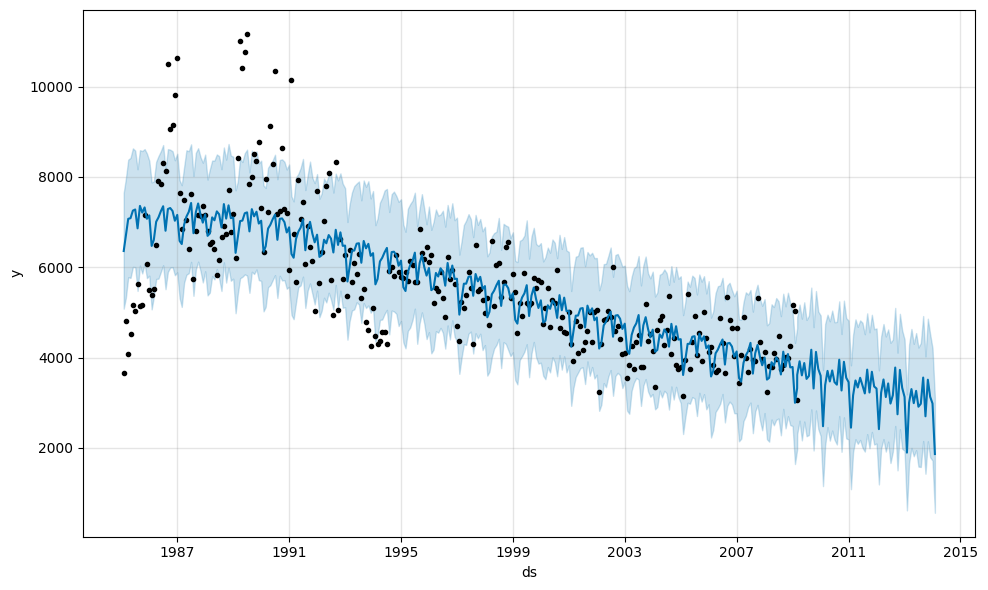

In [541]:
years = 12
future = m.make_future_dataframe(periods=5*years, freq='MS')
future.tail()
forecast = m.predict(future)

fig1 = m.plot(forecast)
#plt.savefig('PROPHET_FORECAST_1y.png')
#plt.close()

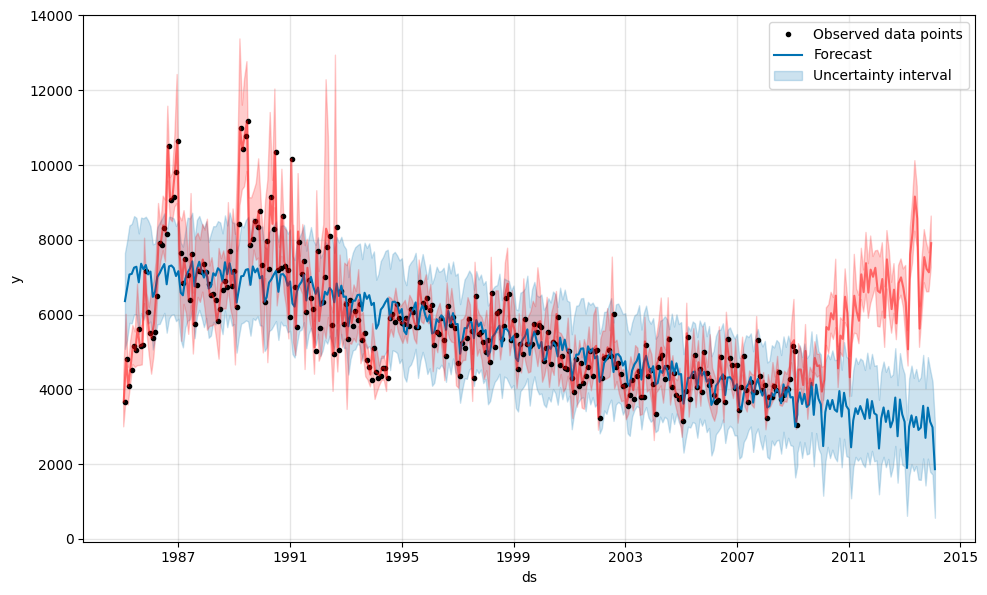

In [542]:
#fig, axs = plt.subplots(2,1, figsize=(20,10))
forecasting_plot = m.plot(forecast)
real_plot = sns.lineplot(data=test, x='DATA_LANC', y='PC_AU_ATU', color='red', alpha=0.5)

In [327]:
test

,Unnamed: 0.1,ID,TIPO_EMP,MES_LAN,ANO_LAN,DATA_ENT,DIST,SUBPREF,MUNICIPIO,TIPO_VIA,...,PERC_PPI,PC_TT_ATU_log,PC_M2_AU_log,PC_M2_AT_log,VLR_US__CO_log,PCMEDAU10_log,RENRESP10_log,PC_AU_ATU_log,REGIAO,DATA_LANC
290,290,10492,VERTIC,15-NOV-2006,2006,15-DEC-2008,JARDIM SAO LUIS,M BOI MIRIM,SAO PAULO,Estr,...,51.456306,11.927765,7.556418,6.942601,0.693147,8.328303,6.897149,7.995549,Sul,2006-11-15
291,291,10493,VERTIC,15-NOV-2006,2006,15-DEC-2008,JARDIM SAO LUIS,M BOI MIRIM,SAO PAULO,Estr,...,51.456306,12.146802,7.522573,6.992914,0.693147,8.328303,6.897149,7.961705,Sul,2006-11-15
292,292,11761,VERTIC,15-MAY-2008,2008,15-OCT-2010,JARDIM SAO LUIS,M BOI MIRIM,SAO PAULO,Rua,...,25.174826,12.544550,7.910946,7.283462,0.693147,8.328303,7.043369,8.221078,Sul,2008-05-15
293,293,11762,VERTIC,15-MAY-2008,2008,15-OCT-2010,JARDIM SAO LUIS,M BOI MIRIM,SAO PAULO,Rua,...,25.174826,12.669528,8.035923,7.248796,0.693147,8.328303,7.043369,8.346056,Sul,2008-05-15
294,294,13279,HORIZ,15-MAR-2010,2010,15-MAR-2010,JARDIM SAO LUIS,M BOI MIRIM,SAO PAULO,Rua,...,25.174826,12.964465,7.859626,7.628639,0.693147,8.328303,7.043369,8.120276,Sul,2010-03-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16930,16930,15848,VERTIC,15-DEC-2012,2012,15-DEC-2013,FORA-SP,FORA-SP,MOGI DAS CRUZES,Rua,...,25.724638,12.154516,8.033568,7.419692,0.693147,8.328303,6.959009,8.087373,RMSP,2012-12-15
16931,16931,15842,VERTIC,15-DEC-2012,2012,15-JUL-2013,FORA-SP,FORA-SP,MOGI DAS CRUZES,Rua,...,36.173634,12.111260,8.007064,7.506213,0.693147,8.328303,6.959009,8.060868,RMSP,2012-12-15
16932,16932,15843,HORIZ,15-DEC-2012,2012,15-FEB-2013,FORA-SP,FORA-SP,MOGI DAS CRUZES,Rua,...,36.173634,11.903202,7.755052,7.531911,0.693147,8.328303,6.959009,7.808855,RMSP,2012-12-15
16933,16933,9739,HORIZ,15-AUG-2005,2005,15-JAN-2006,FORA-SP,FORA-SP,GUARAREMA,Rua,...,29.761904,12.169027,7.231902,6.493285,0.693147,8.328303,7.074599,7.714682,RMSP,2005-08-15


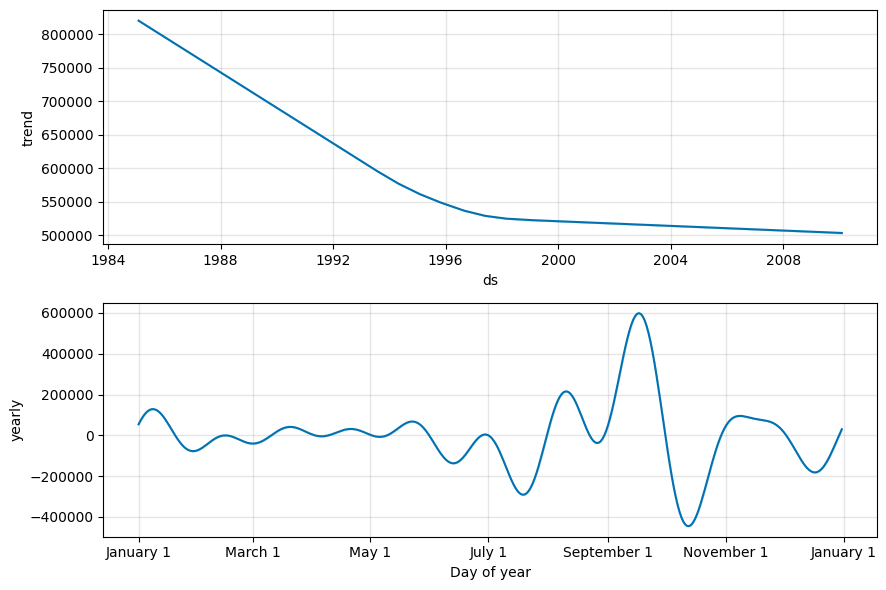

In [319]:
fig = m.plot_components(forecast)